# SURROGATE MODELS POSTPROCESSING NOTEBOOK

This python notebook is used to generate effective plots for the results obtained on an X-capacitive accelerometer, accounting for unknown overecth, offset and thickness.

We will start by training the surrogate modelling, plotting the predictions, and then we will start the identiifcation procedure.

##### Importing Necessary Libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/utils/')

from model import NN_Model
from training import train
from preprocessing import preprocessing
from postprocessing import *

## First Surrogate Model training

We start training the surrogate model, in order to do so we use the corresponding configuration file. In addition we set some values in order to hide confidential information in the plots.

In [2]:
# CONFIGURATION FILE
CONFIGURATION_FILE = './config_I.json'

mean_overetch = 0.3
mean_offset = 0.0
mean_thickness = 30.0
mean_qFactor = 0.5

sigma_O = 0.2
sigma_U = 0.5
sigma_T = 1.0
sigma_Q = 0.1 

We start importing the dataset, through the preprocessing utility. Then we plot the data, subdivided in validation and training sets

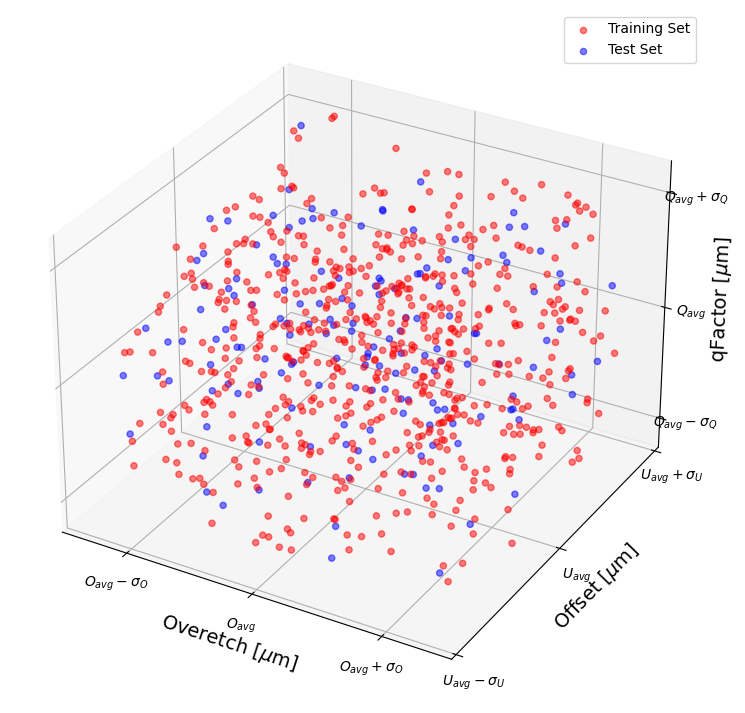

In [3]:
# Preprocessing
data_processor = preprocessing(CONFIGURATION_FILE)

# Collecting traing and Testing Data
X_train = data_processor.X_train
X_test = data_processor.X_test
y_train = data_processor.y_train
y_test = data_processor.y_test

# Time steps of the simulations
time = data_processor.time

fs = 1e5;

# Scaled and processed data
X_train_scaled = data_processor.X_train_scaled
X_test_scaled = data_processor.X_test_scaled 

labels = [
    'Overetch [${\mu}$m]', 
    'Offset [${\mu}$m]', 
    'qFactor [${\mu}$m]'
    ]

ticks = [
    [mean_overetch - sigma_O + 0.05, mean_overetch, mean_overetch + sigma_O - 0.05],
    [mean_offset - sigma_U + 0.05, mean_offset, mean_offset + sigma_U - 0.05],
    [mean_qFactor - sigma_Q + 0.01, mean_qFactor, mean_qFactor + sigma_Q-0.01]
]

ticks_labels = [
    ['$O_{avg}-\sigma_O$', '$O_{avg}$', '$O_{avg}+\sigma_O$'],
    ['$U_{avg}-\sigma_U$', '$U_{avg}$', '$U_{avg}+\sigma_U$'],
    ['$Q_{avg}-\sigma_Q$', '$Q_{avg}$', '$Q_{avg}+\sigma_Q$']
]


plot_dataset(X_train[:,[0,1,3]], X_test[:,[0,1,3]], features_labels=labels, features_ticks=ticks, features_ticks_labels=ticks_labels, digits='%.2f', projection='3d')

### Fast Fourier Transform

Here, we plot the fast Fourier transform of the results. We can use it to compress the signal information and accelrate identification


[8.90592408e-26 3.42887517e+05 7.88611439e+03 4.47695986e+05
 5.68099756e+05 1.03451839e+05 1.60403038e+04 3.81408568e+04
 8.10826113e+03 1.96201464e+02 7.01212968e+01 5.72716791e+01
 1.11120757e+01 9.75998981e-02 1.13027947e+00 8.23079578e-01
 7.18763914e-02 1.96363238e-03 2.40677314e-03 6.80432196e-03
 3.20096254e-03 8.14756272e-04 7.68806123e-04 1.16526795e-04
 2.79165319e-04 4.17141976e-04 1.38147315e-04 3.63073490e-04
 1.96219956e-04 2.02387917e-04 3.11462493e-04 6.87751901e-05
 1.81143733e-04 1.03497000e-04 1.88637280e-04 1.23659957e-04
 9.78121273e-05 2.31337954e-04 7.97924015e-05 1.13631089e-04
 1.78501994e-04 5.56228260e-05 1.01217835e-04 1.12507058e-04
 9.35415568e-05 1.40471662e-04 6.19723483e-05 1.22404502e-04
 5.62988065e-05 9.29745129e-05 1.12570685e-04 5.51284712e-05
 9.59168814e-05 6.42479150e-05 7.02865322e-05 9.28802982e-05
 6.57422995e-05 6.47175000e-05 7.20517832e-05 6.70899011e-05
 7.50135995e-05 4.66074920e-05 7.14025614e-05 5.80286610e-05
 5.28901636e-05 7.348531

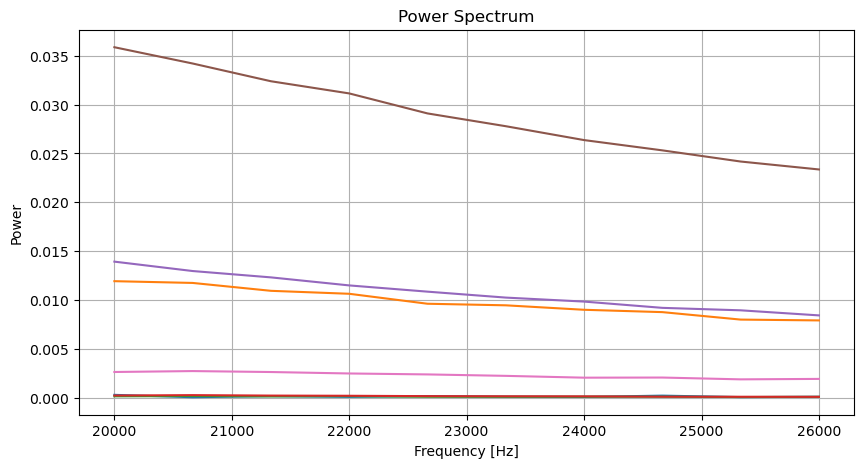

In [4]:
plt.figure(figsize=(10, 5))

for y in y_train[::100]:

    fft_values = np.fft.fft(y-np.mean(y));

    # Get the power spectrum (magnitude of the fft values)
    power_spectrum = np.abs(fft_values)**2

    # Corresponding frequency axis
    freq = np.fft.fftfreq(time.size, 1/fs)

    pos_mask = freq >= 0
    freqs = freq[pos_mask]
    powers = power_spectrum[pos_mask]

    print(powers)
    plt.plot(freqs[30:40], powers[30:40])  # Plot the power spectrum

plt.title('Power Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.grid(True)
plt.show()


### Surrogate Model Training

Then, we train the model. If you want you can use a pretrained model, just changing the flag.

In [5]:
training = False

if training:
    train(CONFIGURATION_FILE)

model_I = NN_Model()
model_I.load_model(data_processor.config['MODEL_PATH'])

### Accuracy

We now plot the predictions of the surrogate model with respect to real validation data.

If the predictions are not accurate enough, enrich model, improve training parameter or increase the number of training epochs.

2024-05-06 17:53:56.790691: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


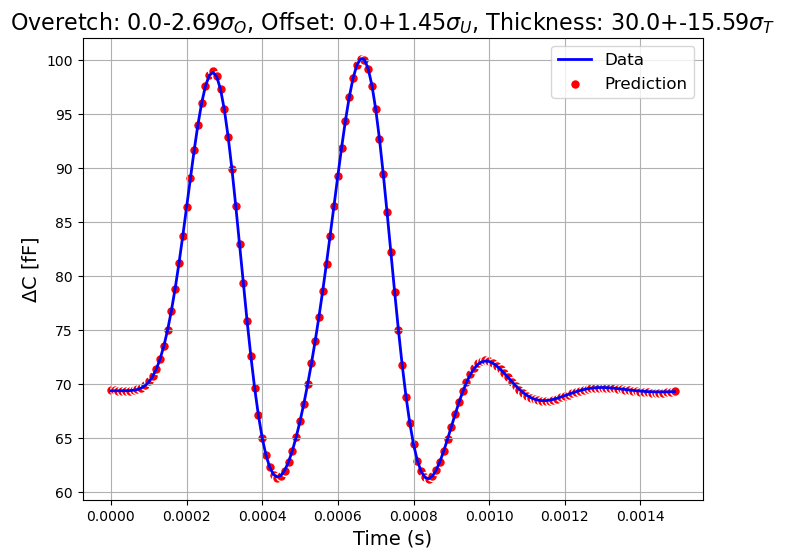

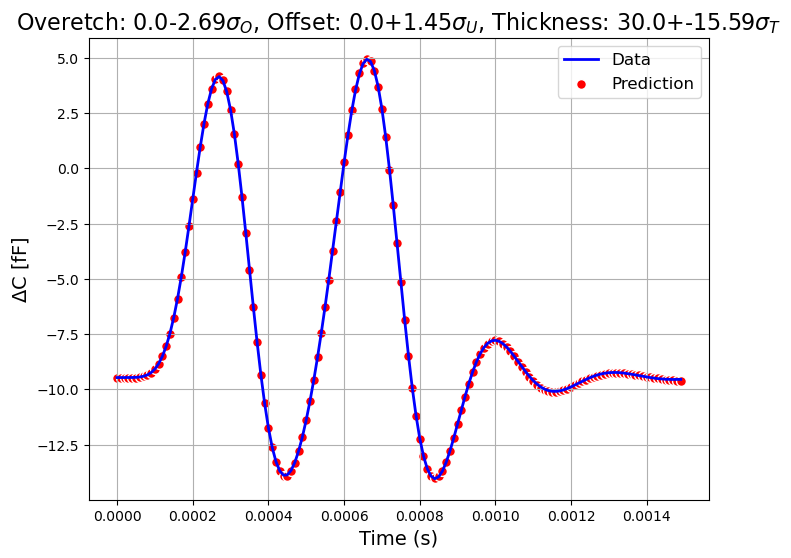

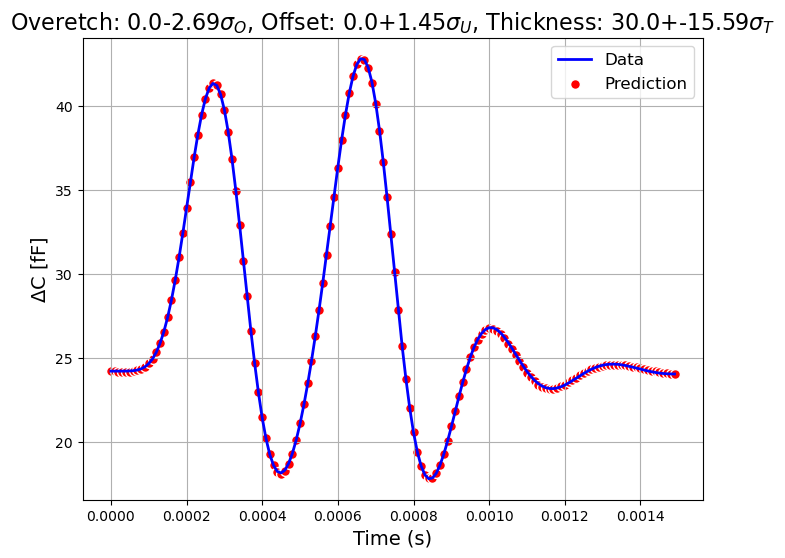

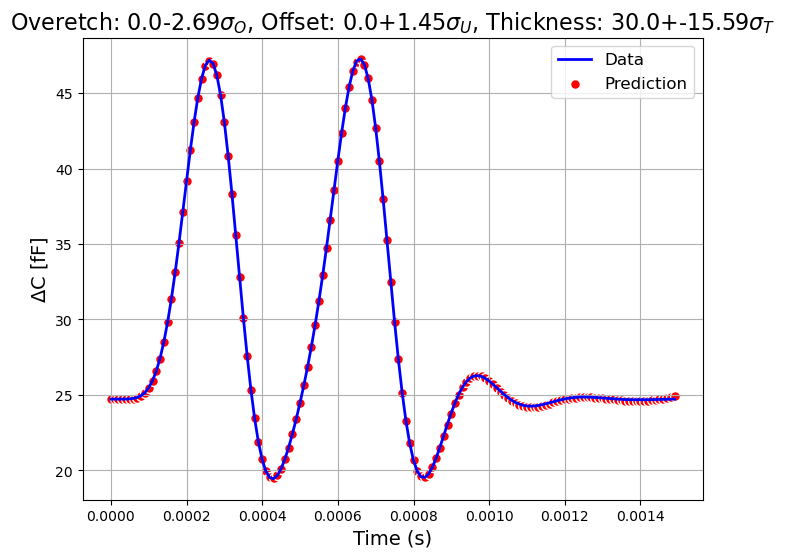

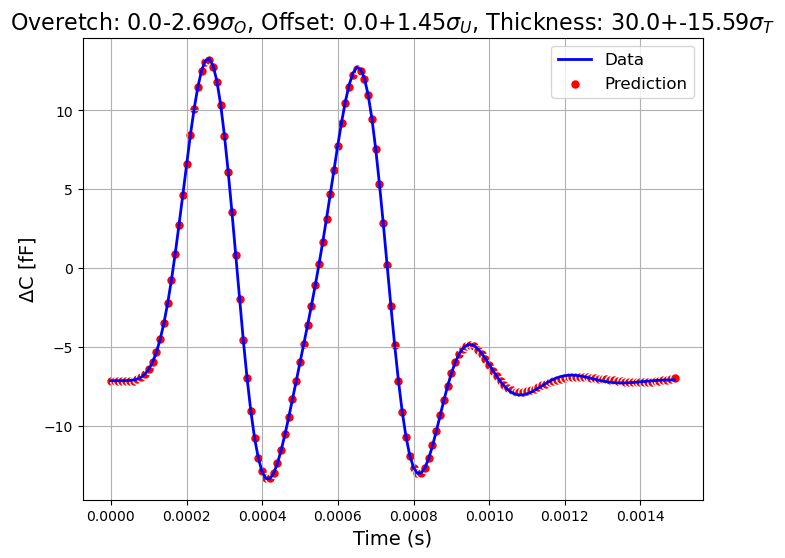

In [6]:
plot_predictions(model_I, y_test, X_test_scaled, time, max_plots=5)
